# DWM (Dynamic Weighted Majority)

In this notebook the algorithm DWM for concept drift handleling is implemented.

## Dependencies

In [2]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import warnings

## Dwm Implementation


* **Concept Drift:** It is the phenomena in which the label of data instances shifts over time, i.e., two similar samples will have different label depending on the time.

* **Ensemble Methods:** It is the method in which several learnes are used to train different classifiers to later predict the class label based on a voting or weighted approach.

    * *Bagging*
    * *Boosting*
    * *Stacking*
    
**<font color=blue>DWM algorithm</font>**

* ***Description:***

    - The formal algorithm for DWM appears in Figure 1. The algorithm maintains a set of m experts, E, each with a weight, wi for i = 1,...,m. Input to the algorithm is n training examples, each consisting of a feature vector and a class label. The parameters also include the number of classes(c) and β, a multiplicative factor that DWM uses to decrease an expert’s weight when it predicts incorrectly. A typical value for β is 0.5. The parameter θ is a threshold for removing poorly performing experts. If an expert’s weight falls below this threshold, then DWM removes it from the ensemble. Finally, the parameter p determines how often DWM creates and removes experts. We found this parameter useful and necessary for large or noisy problems, which we discuss further inSection 4.2. In the following discussion, we assume p = 1. 
    
    - DWM begins by creating an ensemble containing a single learner with a weight of one (lines 1–3 of Figure 1). Initially, this learner could predict a default class, or it could predict using previous experience, background knowledge, or both. DWM then takes a single example (or perhaps a set ofexamples) from the stream and presents it to the single learner to classify (line 7). If the learner’s prediction is wrong (line 8), then DWM decreases the learner’s weight by multiplying it by β (line 9). Since there is one expert in the ensemble, its prediction is DWM’s global prediction (lines 12 and 24). 
    
    - If DWM’s global prediction is incorrect (line 16), then it creates a new learner with a weight of one (lines 17–19). DWM then trains the experts in the ensemble on the new example (line 23). After training, DWM outputs its global prediction (line 24). When there are multiple learners, DWM obtains a classification from each member of the ensemble (lines 6 and 7). If one’s prediction is incorrect, then DWM decreases its weight (lines 8 and 9). Regardless of the correctness of the prediction, DWM uses each learner’s prediction and its weight to compute a weighted sum for each class (line 10). The class with the most weight is set as the global prediction (line 12). 
    
    - Since DWM always decreases the weights of experts, it normalizes the weights by scaling them uniformly so that, after the transformation, the maximum weight is one (line 14). This prevents newly added experts from dominating predictions. DWM also removes poorly performing experts by removing those with a weight less than the threshold θ (line 15), although it will not remove the last expert in the ensemble. As mentioned previously, if the global prediction is incorrect (line 16), DWM adds a new expert to the ensemble with a weight of one (lines 17–19). Finally, after using the new example to train each learner in the ensemble (lines 22 and 23), DWM outputs the global prediction, which is the weighted vote of the expert predictions (line 24).
    
    - As mentioned previously, the parameter p lets DWM better cope with many or noisy examples. p defines the period over which DWM will not update learners’ weights (line 8) and will not remove or create experts (line 13). During this period, however, DWM still trains the learners (lines 22 and 23).
    
    - DWM is a general algorithm for coping with concept drift. One can use any online learning algorithm as the base learner. To date, we have evaluated two such algorithms, naive Bayes and Incremental Tree Inducer, and we describe these versions in the next two sections.

 
* ***Elements:***

    - m: Number of experts
    - E: Expert
    - wj: Expert's weight
    - n: Input training samples
    - c: number of classes
    - β: decreasing weight factor (0 ≤ β < 1)
    - θ: Removing learner weight threshold
    - p: How often DWM removes or update weights
    - Λ,λ ∈ {1,..., c}: global and local predictions


* ***Algorithm:***

    / 1. m ← 1

    / 2. em ← Create-New-Expert()

    / 3. wm ← 1

    / 4. for i ← 1,...,n // Loop over examples

        / 5. ~σ ← 0

        / 6. for j ← 1,...,m // Loop over experts

            / 7. λ ← Classify(e j,~xi)

            / 8. if (λ 6= yi and i mod p = 0)

                / 9. wj ← βwj

            / 10. σλ ← σλ +wj

        / 11. end;

        / 12. Λ ← argmaxj σj

        / 13. if (i mod p = 0)

            / 14. w ← Normalize-Weights(w)

            / 15. {e,w} ← Remove-Experts({e,w},θ)

            / 16. if (Λ 6= yi)

                / 17. m ← m+1

                / 18. em ← Create-New-Expert()

                / 19. wm ← 1

            / 20. end;

        / 21. end;

        / 22. for j ← 1,...,m

            / 23. e j ← Train(e j,~xi, yi)

            / 24. output Λ

        end;

    end

## 1. Functions

In [3]:
def norm_weights(w):
    #######################################################
    # INPUT
    # w: list with learners weights
    #
    # OUTPUT
    # w: updated list with normalized weights. The weights are normalized so the highest weight is 1
    ########################################################
    maximum = w[0]
    for i in range(1,len(w)):
        if maximum < w[i]:
            maximum = w[i]
    for i in range(len(w)):
        w[i] = w[i] / maximum
    return w

In [4]:
def remove_experts(E, w, theta, m):
    #######################################################
    # INPUT
    # E: list with learners
    # w: list with weights
    # theta: weight threshold to eliminate learner
    # m: current number of learners
    #
    # OUTPUT
    # list_E: Updated list of learners without model which weight was lower than theta
    # list_w: Updated list of weights where the weight corresponding to the eliminated learner is dropped
    # m: Updated number of learners
    ########################################################
    list_E = []
    list_w = []
    for i in range(len(w)):
        if w[i] >= theta:
            list_E.append(E[i])
            list_w.append(w[i])
        else:
            m = m - 1
    return list_E, list_w, m

In [5]:
def avg_acc(l):
    #######################################################
    # INPUT
    # l: array (m x n), where m indicates the accuracies of one run of the algorithm throughout all the time units and n represents the different runs of the algorithm
    #
    # OUTPUT
    # average: list in which every element reresents the mean of the accuracies of the different run at each different time
    ########################################################
    average = []
    for i in range(len(l[0])):
        suma = 0
        for j in range(len(l)):
            suma = suma + l[j][i]
        average.append(suma / len(l))
    return average

In [6]:
def replace_experts(E, w):
    #######################################################
    # When there is a maximum number of learners constraint this function is used to replace the learner with lower weight for a new learner
    # INPUT
    # E: list with learners
    # w: list with weights
    #
    # OUTPUT
    # list_E: Updated list of learners without model which weight was lower than theta
    # list_w: Updated list of weights where the weight corresponding to the eliminated learner is dropped
    ########################################################
    i = np.argmin(w)
    w[i] = 1
    E[i] = GaussianNB()
    return E, w

In [7]:
def plot_performance(acc_DWM, acc_normal, acc_perfect, elements, bottom = 0, top = 1):
    #######################################################
    # INPUT
    # Lists with the values to be ploted
    # List with the number of elements
    ########################################################
    plt.figure(figsize=(10,10))
    
    # Performance plot
    plt.subplot(2,1,1)
    axes = plt.gca()
    axes.set_ylim([bottom, top])
    line1, = plt.plot(acc_DWM, label = 'DWM-NB')
    line2, = plt.plot(acc_normal, label = 'NB', ls = '--')
    line3, = plt.plot(acc_perfect, label = 'NB Perfect Forgetting', ls = '--')
    plt.ylabel('Accuracy')
    plt.xlabel('time')
    plt.legend(handles = [line1, line2, line3])
    
    # Number of elements plot
    plt.subplot(2,1,2)
    plt.plot(elements)
    plt.ylabel('Learners')
    plt.xlabel('time')
    
    plt.show()

## 2. STAGGER Concepts

First the DWM model will be evaluated with artificial datasets used to evaluate models performance with respect to concept drift. First, the STAGGER concepts are used.

The STAGGER concepts constitute a way of creating a streaming dataset to evaluate the response of an algortihm to concept drift.

It includes three attributes with 3 values per asttribute. The strategy is to label as True or False different combinations of attributes in sucessive time slots to evaluate the performance.

* **Attributes:**
    - ***Color:*** Green, blue and red.
    - ***Shape:*** Triangle, circle and rectangle.
    - ***Size:*** Small, medium and large.
    
The presentation of training examples lasts for 120 time steps, and at each time step, the learner receives one example. For the first 40 time steps, the target concept is color = red ∧ size = small. During the next 40 time steps, the target concept is color = green ∨ shape = circle. Finally, during the last 40 time steps, the target concept is size = medium ∨ size = large. A visualization of these concepts.

To evaluate the learner, at each time step, one randomly generates 100 examples of the current target concept, presents these to the performance element, and computes the percent correctly predicted. In our experiments, we repeated this procedure 50 times and averaged the accuracies over these runs. We also computed 95% confidence intervals.

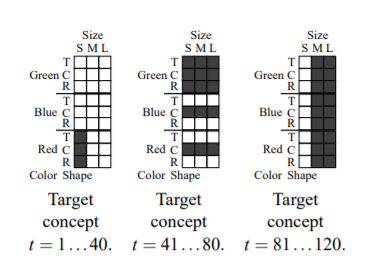

In [8]:
from IPython.display import Image
Image("STAGGER_image.png")

### Function to create STAGGER concepts dataset

In [9]:
def gen_stagger(number, time, max_time):
    #######################################################
    # INPUT
    # number: Number of samples to generate within the same concept domain
    # time: Current timestamp at which the samples are generated. It is used to define the label based on the concept domain the timestampt corresponds to.
    # max_time: maximum timestampts in the stream. Used to calculate the boundaries for concept drift
    # 
    # OUTPUT
    # df: dataframe containing the specified number of samples with labels assigned matching to the current (time) concept
    ########################################################
    attr = {'color' : ['Red', 'Green', 'Blue'],
            'shape' : ['Triangle', 'Circle', 'Rectangle'],
            'size' : ['Small', 'Medium', 'Large']}
    # Define lists
    color_list = []
    shape_list = []
    size_list = []
    label_list = []
    # Loop to create the required data n
    for n in range(number):
        color_list.append(attr['color'][np.random.randint(len(attr['color']))])
        shape_list.append(attr['shape'][np.random.randint(len(attr['shape']))])
        size_list.append(attr['size'][np.random.randint(len(attr['size']))])
        if(time < max_time / 3):
            if(color_list[n] == 'Red' and size_list[n] == 'Small'):
                label_list.append(1)
            else:
                label_list.append(0)
        elif(max_time / 3 <= time and time < max_time * 2 / 3):
            if(color_list[n] == 'Green' or shape_list[n] == 'Circle'):
                label_list.append(1)
            else:
                label_list.append(0)
        else:
            if(size_list[n] == 'Medium' or size_list[n] == 'Large'):
                label_list.append(1)
            else:
                label_list.append(0)
    # Build dict            
    data = {'color' : color_list,
            'shape' : shape_list,
            'size' : size_list,
            'label' : label_list}
    # Build dataframe
    df = pd.DataFrame(data, columns = ['color', 'shape', 'size', 'label'])
    # returns data frame
    df = pd.get_dummies(df, prefix=['color', 'shape', 'size'], columns=['color', 'shape', 'size'])
    
    df = df[['color_Blue','color_Green','color_Red','shape_Circle','shape_Rectangle','shape_Triangle','size_Large','size_Medium','size_Small','label']]
    return df
    

### Implementation of DWM for STAGGER concepts

Since all the attributes of the dataset are binary we use **Bernoulli Naives Classifier**

In [14]:
def evaluateDWM_stagger(n_eval, max_time, beta = 0.5, theta = 0.01, loops = 10):
    #######################################################
    # INPUT
    # n_eval: Number of samples minus one(the first sample is used to train) to evaluate per unit of time
    # max_time: Number of units of time
    # beta: Weight decreasing factor
    # theta: Weight elimination threshold
    # loops: number of runs of the algorithm
    # 
    # OUTPUT
    # Plot of the accuracy over time
    # PLot of number of learners over time
    ########################################################
    accuracy_DWM_mean, accuracy_normal_mean, accuracy_perfect_mean, elements_mean= [], [], [], []
    for l in tqdm(range(loops)):
        # Initialize number of classifiers to 1
        m = 1
        # Number of classes
        c = 2
        # Create first classifier and weight
        E = []
        E.append(BernoulliNB())
        normal_model = BernoulliNB()
        perfect_model = BernoulliNB()
        # The first fit is performed with a randomly generated sample with a default label of 1
        E[0].partial_fit(np.random.randint(2, size = (1,9)), np.array([1]), classes = [0,1])
        normal_model.partial_fit(np.random.randint(2, size = (1,9)), np.array([1]), classes = [0,1])
        perfect_model.partial_fit(np.random.randint(2, size = (1,9)), np.array([1]), classes = [0,1])
        w = []
        w.append(1)
        # Lists for performance evaluation
        Y, accuracy_DWM, accuracy_normal, accuracy_perfect, elements = [], [], [], [], []
        for i in tqdm(range(max_time)):
            df = gen_stagger(n_eval, i, max_time)
            # Generate 100 samples 1 for training 99 for testing
            x_train = df.to_numpy()[0][0:len(df.to_numpy()[0])-1]
            x_test = df.to_numpy()[1:100][:,0:len(df.to_numpy()[0])-1]
            y_train = df.to_numpy()[0][len(df.to_numpy()[0])-1]
            y_test = df.to_numpy()[1:100][:,len(df.to_numpy()[0])-1]
            # Create the prediction array
            local_pred = np.array(np.zeros(c))

            # Predict for every learner from DWM
            for j in range(m):
                y_pred = E[j].predict(np.array(x_train, ndmin = 2))
                if(y_pred != y_train):
                    w[j] = w[j] * beta
                local_pred[y_pred] = local_pred[y_pred] + w[j]
            global_pred = np.argmax(local_pred)

            # Online evaluation of the model. Every time the model is fit, the model is evaluated in other 99 samples

            # Evaluate DWM
            local_pred_test = np.zeros((x_test.shape[0], c))
            for j in range(m):
                y_pred_DWM = E[j].predict(x_test)
                for k in range(local_pred_test.shape[0]):
                    local_pred_test[k][y_pred_DWM[k]] = local_pred_test[k][y_pred_DWM[k]] + w[j]
            global_pred_test = np.argmax(local_pred_test, axis=1)
            accuracy_DWM.append(accuracy_score(y_test, global_pred_test))

            # Evaluate Normal
            y_pred_normal = normal_model.predict(x_test)
            accuracy_normal.append(accuracy_score(y_test, y_pred_normal))

            # Evaluate Perfect
            y_pred_perfect = perfect_model.predict(x_test)
            accuracy_perfect.append(accuracy_score(y_test, y_pred_perfect))

            # Reset perfect classifier when a concept drift takes place
            if( i == (max_time / 3) - 1 or i == (2 * max_time / 3) -1):
                perfect_model = BernoulliNB()

            # Normalize weights and if the case eliminate elements of DWM
            w = norm_weights(w)
            elements.append(m)
            E, w, m = remove_experts(E, w, theta, m)
            if(global_pred != y_train):
                m = m + 1
                E.append(BernoulliNB())
                w.append(1)

            # Partial fit of DWM 
            for j in range(m):
                E[j].partial_fit(np.array(x_train, ndmin = 2), np.array(y_train, ndmin = 2), classes = [0,1])
            Y.append(global_pred)

            # Partial fit of normal model
            normal_model.partial_fit(np.array(x_train, ndmin = 2), np.array(y_train, ndmin = 2), classes = [0,1])

            # Partial fit of perfect model
            perfect_model.partial_fit(np.array(x_train, ndmin = 2), np.array(y_train, ndmin = 2), classes = [0,1])
        accuracy_DWM_mean.append(accuracy_DWM)
        accuracy_normal_mean.append(accuracy_normal)
        accuracy_perfect_mean.append(accuracy_perfect)
        elements_mean.append(elements)
        
    # Plot results
    plot_performance(avg_acc(accuracy_DWM_mean),avg_acc(accuracy_normal_mean), avg_acc(accuracy_perfect_mean), avg_acc(elements_mean), top=1.05)

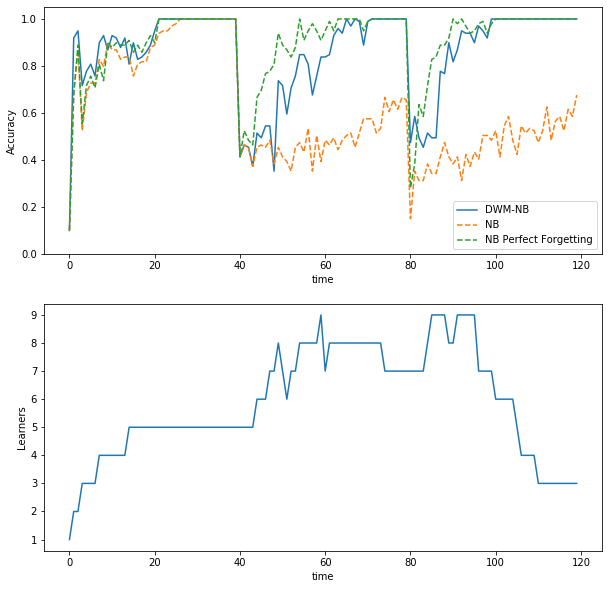

In [15]:
# 1 Run
evaluateDWM_stagger(1000, 120, loops=1)

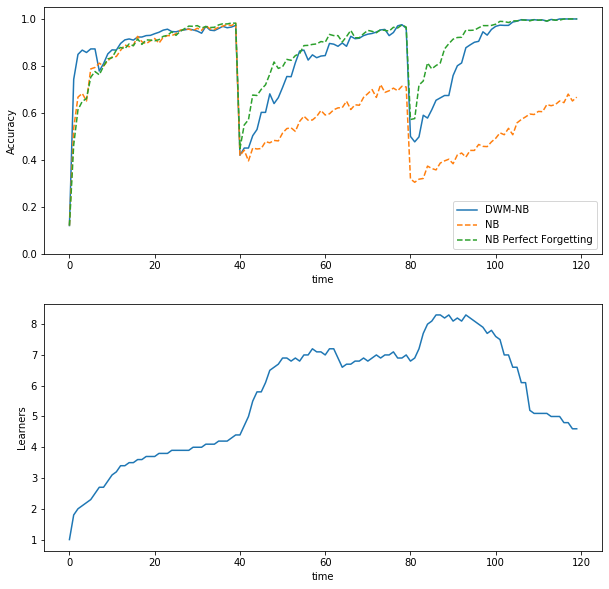

In [16]:
# 10 Runs
x = evaluateDWM_stagger(1000, 120, loops=10)

## 3. SEA Concepts

To determine how well DWM-NB performs on larger problems involving concept drift, we evaluated
it using a synthetic problem recently proposed in the data mining community (Street and Kim,
2001). This problem, which we call the “SEA concepts”, consists of three attributes, xi ∈ R such
that 0.0 ≤ xi ≤ 10.0. The target concept is x1 + x2 ≤ b, where b ∈ {7,8,9,9.5}. Thus, x3 is an
irrelevant attribute.

The presentation of training examples lasts for 50,000 time steps. For the first fourth (i.e.,
12,500 time steps), the target concept is with b = 8. For the second, b = 9; the third, b = 7; and
the fourth, b = 9.5. For each of these four periods, we randomly generated a training set consisting
of 12,500 examples. In one experimental condition, we added 10% class noise; in another, we did
not, and this latter condition served as our control. We also randomly generated 2,500 examples
for testing. At each time step, we presented each method with one example, tested the resulting
concept descriptions using the examples in the test set, and computed the percent correct. We
repeated this procedure ten times, averaging accuracy over these runs. We also computed 95%
confidence intervals

#### Function to build dataset

In [18]:
def gen_sea(max_time, number = 0, time = 0, option = 0):
    #######################################################
    # INPUT
    # Both training and test sets are build with that function
    # if option == 0:
    # number: Number of samples to generate within the same concept domain
    # time: Current timestamp at which the samples are generated. It is used to define the label based on the concept domain the timestampt corresponds to.
    # max_time: maximum timestampts in the stream. Used to calculate the boundaries for concept drift
    # if option == 1:
    # time: Current timestamp at which the samples are generated. It is used to define the label based on the concept domain the timestampt corresponds to.
    # max_time: maximum timestampts in the stream. Used to calculate the boundaries for concept drift and for each time step within max_time a sample is generated
    #
    # OUTPUT
    # df: dataframe containing the specified number of samples with labels assigned matching to the current (time) concept
    ########################################################
    # Define lists
    x1 = []
    x2 = []
    x3 = []
    label_list = []
    if(option == 0):
        # Loop to create the required data n
        for n in range(number):
            x1.append(np.random.uniform(0,10))
            x2.append(np.random.uniform(0,10))
            x3.append(np.random.uniform(0,10))
            if((time < max_time / 4) and ((x1[n] + x2[n]) <= 8)):
                label_list.append(1)
            elif((max_time / 4 <= time and time < max_time / 2) and ((x1[n] + x2[n]) <= 9)):
                label_list.append(1)
            elif((max_time / 2 <= time and time < max_time * 3 / 4) and ((x1[n] + x2[n]) <= 7)):
                label_list.append(1)
            elif((max_time * 3 / 4 <= time) and ((x1[n] + x2[n]) <= 9.5)):
                label_list.append(1)
            else:
                label_list.append(0)
    else:
        for n in range(max_time):
            x1.append(np.random.uniform(0,10))
            x2.append(np.random.uniform(0,10))
            x3.append(np.random.uniform(0,10))
            if((n < max_time / 4) and ((x1[n] + x2[n]) <= 7)):
                label_list.append(0)
            elif((max_time / 4 <= n and n < max_time / 2) and ((x1[n] + x2[n]) <= 8)):
                label_list.append(0)
            elif((max_time / 2 <= n and n < max_time * 3 / 4) and ((x1[n] + x2[n]) <= 9)):
                label_list.append(0)
            elif((max_time * 3 / 4 <= n) and ((x1[n] + x2[n]) <= 9.5)):
                label_list.append(0)
            else:
                label_list.append(1)
                
    # Build dict            
    data = {'x1' : x1,
            'x2' : x2,
            'x3' : x3,
            'label': label_list
            }
    # Build dataframe
    df = pd.DataFrame(data, columns = ['x1', 'x2', 'x3', 'label'])
    return df

### DWM for SEA concepts

#### Function to build DWM for sea concepts

In [19]:
def evaluateDWM_sea(max_time, beta = 0.5, theta = 0.01, loops = 5, p = 1, k_max = 0):
    #######################################################
    # INPUT
    # max_time: Number of units of time
    # beta: Weight decreasing factor
    # theta: Weight elimination threshold
    # loops: Number of iterations of the algorithm over the whole stream
    # p: number that determines how often is gonna be updated the algorithm (delete learners, create learners, update learners weights)
    # k_max: maximum number of learners 
    #
    # OUTPUT
    # Plot of the accuracy over time
    # PLot of number of learners over time
    ########################################################
    warnings.filterwarnings("ignore")
    accuracy_DWM_mean, accuracy_normal_mean, accuracy_perfect_mean, elements_mean= [], [], [], []
    for l in tqdm(range(loops)):
        # Train set
        df_train = gen_sea(max_time=max_time, option = 1)
        # Test Set
        # We use 2000 test samples in total, which means 500 samples for every concept
        df_test = gen_sea(max_time=2000, option = 1)
        df_test_1 = df_test[0:int(df_test.shape[0]/4)]
        df_test_2 = df_test[int(df_test.shape[0]/4):int(df_test.shape[0]/2)]
        df_test_3 = df_test[int(df_test.shape[0]/2):int(3*df_test.shape[0]/4)]
        df_test_4 = df_test[int(3*df_test.shape[0]/4):int(df_test.shape[0])]
        # Initialize number of classifiers to 1
        m = 1
        # Number of classes
        c = 2
        # Create first classifier and weight
        E = []
        E.append(GaussianNB())
        normal_model = GaussianNB()
        perfect_model = GaussianNB()
        # The first fit is performed with a randomly generated sample with a default label of 1
        E[0].partial_fit(np.random.uniform(0,10, size = (1,3)), np.array([1]), classes = [0,1])
        normal_model.partial_fit(np.random.uniform(0,10, size = (1,3)), np.array([1]), classes = [0,1])
        perfect_model.partial_fit(np.random.uniform(0,10, size = (1,3)), np.array([1]), classes = [0,1])
        w = []
        w.append(1)
        # Lists for performance evaluation
        Y, accuracy_DWM, accuracy_normal, accuracy_perfect, elements = [], [], [], [], []
        for i in tqdm(range(max_time)):
            x_train = df_train.to_numpy()[i][0:len(df_train.to_numpy()[0]) - 1]
            y_train = int(df_train.to_numpy()[i][len(df_train.to_numpy()[0]) - 1])
            if(i == 0):
                x_test = df_test_1.to_numpy()[:,0:len(df_train.to_numpy()[0]) - 1]
                y_test = np.array(df_test_1.to_numpy()[:,len(df_train.to_numpy()[0]) - 1], dtype = int)
            elif(i == max_time / 4):
                x_test = df_test_2.to_numpy()[:,0:len(df_train.to_numpy()[0]) - 1]
                y_test = np.array(df_test_2.to_numpy()[:,len(df_train.to_numpy()[0]) - 1], dtype = int)
            elif(i == max_time / 2):
                x_test = df_test_3.to_numpy()[:,0:len(df_train.to_numpy()[0]) - 1]
                y_test = np.array(df_test_3.to_numpy()[:,len(df_train.to_numpy()[0]) - 1], dtype = int)
            elif(i == 3*max_time / 4):
                x_test = df_test_4.to_numpy()[:,0:len(df_train.to_numpy()[0]) - 1]
                y_test = np.array(df_test_4.to_numpy()[:,len(df_train.to_numpy()[0]) - 1], dtype = int)
            # Create the predicion array
            local_pred = np.array(np.zeros(c))

            # Predict for every learner from DWM
            for j in range(m):
                y_pred = E[j].predict(np.array(x_train, ndmin = 2))
                if((y_pred != y_train) and i % p == 0):
                    w[j] = w[j] * beta
                local_pred[y_pred] = local_pred[y_pred] + w[j]
            global_pred = np.argmax(local_pred)
            # Online evaluation of the model. Every time the model is fit, the model is evaluated in other 99 samples

            # Evaluate DWM
            local_pred_test = np.zeros((x_test.shape[0], c))
            for j in range(m):
                y_pred_DWM = E[j].predict(x_test)
                for k in range(local_pred_test.shape[0]):
                    local_pred_test[k][y_pred_DWM[k]] = local_pred_test[k][y_pred_DWM[k]] + w[j]
            global_pred_test = np.argmax(local_pred_test, axis=1)
            accuracy_DWM.append(accuracy_score(y_test, global_pred_test))

            # Evaluate Normal
            y_pred_normal = normal_model.predict(x_test)
            accuracy_normal.append(accuracy_score(y_test, y_pred_normal))

            # Evaluate Perfect
            y_pred_perfect = perfect_model.predict(x_test)
            accuracy_perfect.append(accuracy_score(y_test, y_pred_perfect))

            # Reset perfect classifier when a concept drift takes place
            if( i == (max_time / 4) - 1 or i == (max_time / 2) or i == (3 * max_time / 4) -1):
                perfect_model = GaussianNB()

            # Normalize weights and if the case eliminate elements of DWM
            elements.append(m)
            if(i % p == 0):
                w = norm_weights(w)
                E, w, m = remove_experts(E, w, theta, m)
                if(global_pred != y_train):
                    if(k_max == 0):
                        m = m + 1
                        E.append(GaussianNB())
                        w.append(1)
                    elif(m < k_max):
                        m = m + 1
                        E.append(GaussianNB())
                        w.append(1)
                    else:
                        E, w = replace_experts(E, w)

            # Partial fit of DWM 
            for j in range(m):
                E[j].partial_fit(np.array(x_train, ndmin = 2), np.array(y_train, ndmin = 2), classes = [0,1])
            Y.append(global_pred)
            # Partial fit of normal model
            normal_model.partial_fit(np.array(x_train, ndmin = 2), np.array(y_train, ndmin = 2), classes = [0,1])
            # Partial fit of perfect model
            perfect_model.partial_fit(np.array(x_train, ndmin = 2), np.array(y_train, ndmin = 2), classes = [0,1])
        
        accuracy_DWM_mean.append(accuracy_DWM)
        accuracy_normal_mean.append(accuracy_normal)
        accuracy_perfect_mean.append(accuracy_perfect)
        elements_mean.append(elements)
        
    # Plot results
    plot_performance(avg_acc(accuracy_DWM_mean),avg_acc(accuracy_normal_mean), avg_acc(accuracy_perfect_mean), avg_acc(elements_mean), bottom = 0.7)

#### Evaluate DWM on  SEA with different parameters

**No maximum number of learners**

First we evaliate the DWM in SEA dataset with 50000 time steps in order to have a lot of data to test in a reliable way the algorithm.

We use **p = 50** which means that the ensemble and the weights of the learners are updated every 50 time steps.

**1 run (Demo)**

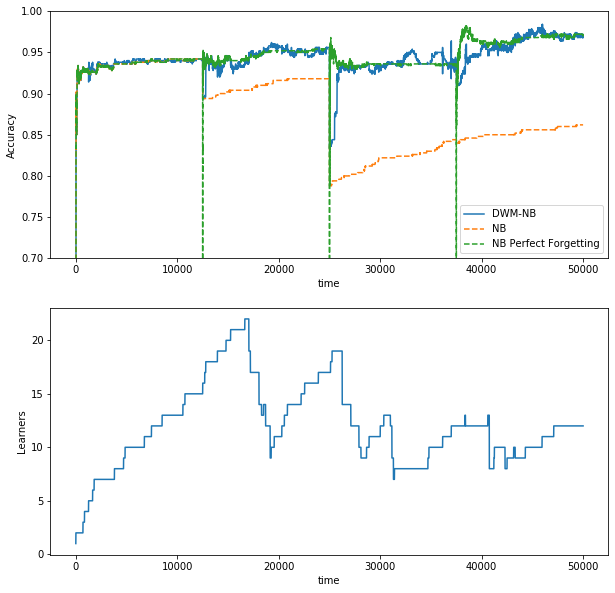

In [20]:
# p = 50, loops = 10, no maximum number of learners, 50000 time steps
evaluateDWM_sea(max_time=50000, p = 50, loops=1)

**10 times run**

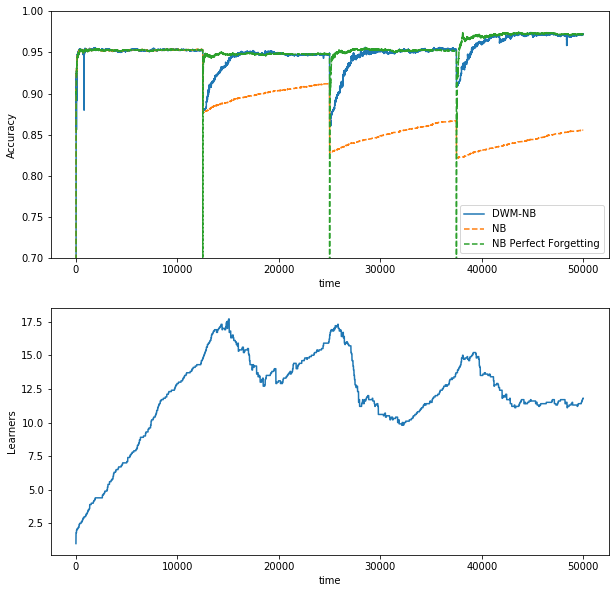

In [59]:
# p = 50, loops = 10, no maximum number of learners, 50000 time steps
evaluateDWM_sea(max_time=50000, p = 50, loops=10)

**Maximum number of learners**

Now we test DWM with the same dataset but with a maximum number of learners. In this test, the maximum number of learners is set to **k_max = 5**. The **p = 50** is mantained and the number of time steps is 50000 again, in that way it is possible to compare with the previous approach.

From the results below it can be seen that the performance of the model it is equal than the one with no number of learners restriction. Furthermore, the computation time is much lower, since at maximum only 5 learners will have to be trained and will have to predict the validation set.

**1 run (Demo)**

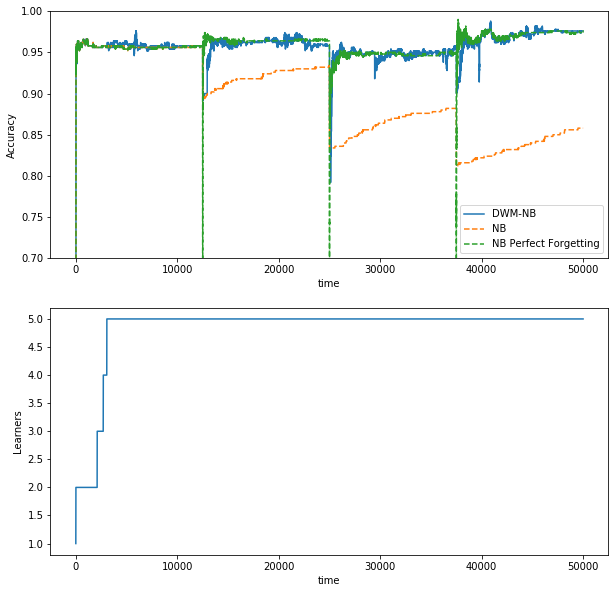

In [22]:
# p = 50, loops = 1, maximum number of learners = 5, 50000 time steps
evaluateDWM_sea(max_time=50000, p=50, loops=1, k_max = 5, theta=0)

**10 times run**

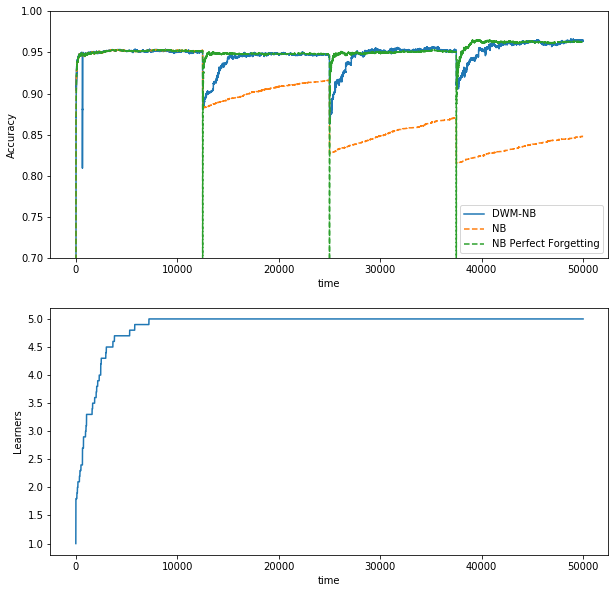

In [58]:
# p = 50, loops = 10, maximum number of learners = 5, 50000 time steps
evaluateDWM_sea(max_time=50000, p=50, loops=10, k_max = 5, theta=0)